<a href="https://colab.research.google.com/github/toraaglobal/SREIT/blob/master/05_Hypothesis_Testing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hypothesis**: University towns have their mean housing prices less effected by recessions.

This hypothesis will be tested using t-test


**Testing**: Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.



The following data files are use for this project:
 
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.





**Import Packages**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from fbprophet import Prophet

%matplotlib inline

**State Dictinary for Name mapping**

In [0]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National',
          'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois',
          'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine',
          'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey',
          'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 
          'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut',
          'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York',
          'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania',
          'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands',
          'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

**Mount Drive**

In [3]:
## OBTAIN


#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/code')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Get List of University Town**

In [4]:
def get_list_of_university_towns(file):
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    text_file = open(file)

    university_towns = pd.read_csv(file, sep = "\n", header = None, names = ["RegionName"])
    ## all state end with [edit] in the text file, extract the state and create a dictionary of state
    State = {idx: lines.strip().replace("[edit]", "")
             for idx,lines in enumerate(text_file) if "edit" in lines}
    ##convert state dict to series
    State = pd.Series(State)
    
    university_towns["State"] = State
    university_towns = university_towns.fillna(method = 'ffill')
    
    ## drop row that has state name in the index
    university_towns = university_towns.drop(State.index)
    
    university_towns["RegionName"] = list(map(lambda x: x.split("(")[0].rstrip(),university_towns["RegionName"]))
    
    university_towns["RegionName"] = list(map(lambda x: x.split("[")[0].rstrip(),university_towns["RegionName"]))
    
    university_towns["State"] =  university_towns["State"].replace('ï»¿Alabama', 'Alabama') 
    
    university_towns = university_towns.set_index(["State", "RegionName"])
       
                
    
    return university_towns
  
  
  
file = "university_towns.txt"

 
uni_town =get_list_of_university_towns(file)

print(type(uni_town))
uni_town.head()

<class 'pandas.core.frame.DataFrame'>


Empty DataFrame
Columns: []
Index: [(﻿Alabama, Auburn), (﻿Alabama, Birmingham), (﻿Alabama, Dothan), (﻿Alabama, Florence), (﻿Alabama, Homewood)]

In [5]:
## reset index of the dataframe
uni_town = uni_town.reset_index()
uni_town.head()

,State,RegionName
0,﻿Alabama,Auburn
1,﻿Alabama,Birmingham
2,﻿Alabama,Dothan
3,﻿Alabama,Florence
4,﻿Alabama,Homewood


In [6]:
temp = uni_town.groupby('State').count().reset_index()
temp

,State,RegionName
0,Alaska,5
1,Arizona,12
2,Arkansas,10
3,California,116
4,Colorado,13
5,Connecticut,18
6,Delaware,4
7,District of Columbia,1
8,Florida,36
9,Georgia,33


In [0]:
temp = temp.drop([38])

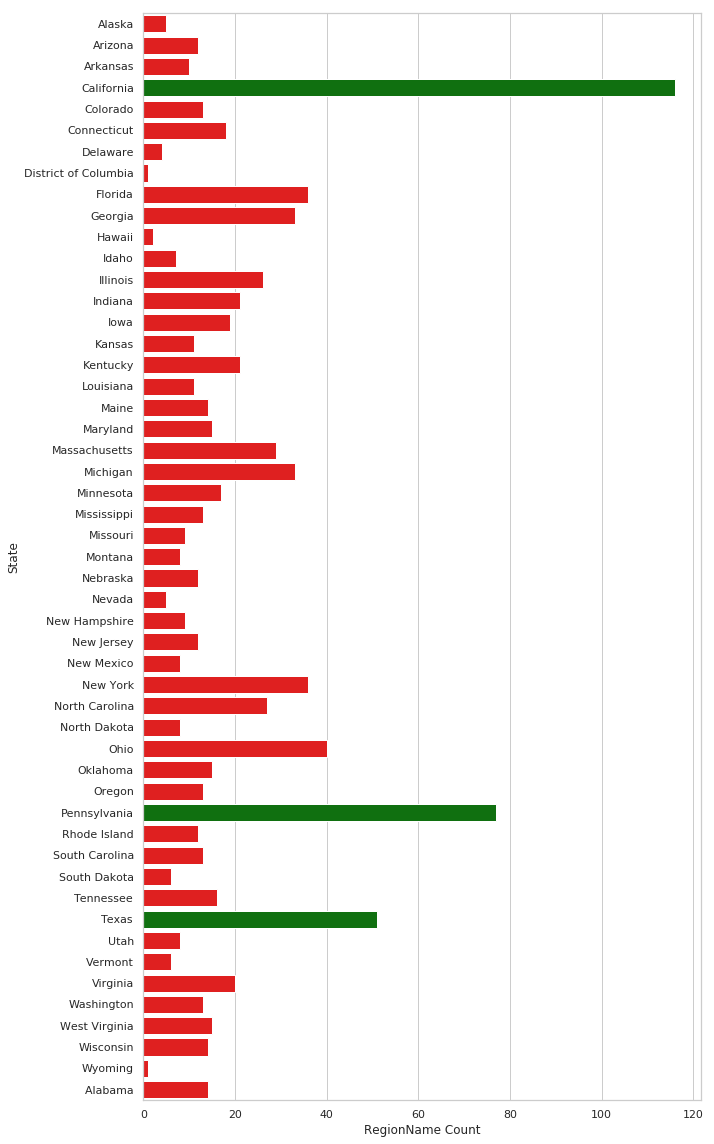

In [8]:
## Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 20))


clrs = ['green' if (x > 50 ) else 'red' for x in temp['RegionName'].values ]

# Plot the Feature Importance
sns.barplot(x="RegionName", y='State', data=temp, label="Total",  palette=clrs)
plt.xlabel("RegionName Count")
plt.show()

**Get GDP**

In [9]:
def getGDP(filename):

        GDP = pd.read_excel(filename, skiprows = 5)

        # Drop all the rows for the data that corresponds to quarters prior to the first
        # quarter of 2000
        GDP.drop(GDP.index[:214], inplace = True)

        GDP.dropna(axis = 1, how = 'all', inplace = True) # drop rows with no values

        # Keep only two columns: Quarter and GDP in billions of chained 2009 dollars
        GDP = GDP.iloc[:,[0,2]]

        # Rename columns
        GDP.columns = ["Quarters", 'GDP in billions in current dollars']

        # Set Quarters as the index to the dataframe
        GDP.set_index("Quarters", inplace = True)
        return GDP
      

filename = "gdplev.xlsx"

gdp= getGDP(filename)
gdp.head()

,GDP in billions in current dollars
Quarters,
2000Q1,12359.1
2000Q2,12592.5
2000Q3,12607.7
2000Q4,12679.3
2001Q1,12643.3


In [10]:
temp2 = gdp.reset_index()
temp2.head()


,Quarters,GDP in billions in current dollars
0,2000Q1,12359.1
1,2000Q2,12592.5
2,2000Q3,12607.7
3,2000Q4,12679.3
4,2001Q1,12643.3


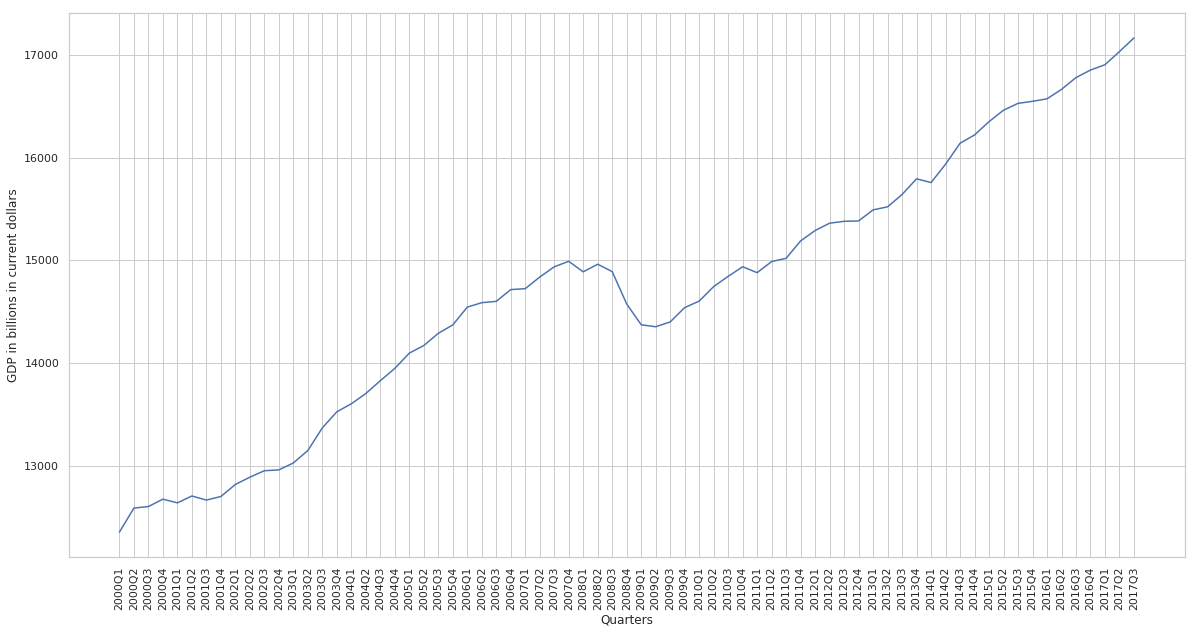

In [11]:
## linplot
plt.figure(figsize=(20,10))
sns.lineplot(temp2['Quarters'],temp2['GDP in billions in current dollars'])
plt.xticks( rotation='vertical')
plt.show()

**Get difference in concecutive gdp**

In [12]:
# get the diffenrece in concecutive gdp
gdp_diff = gdp.diff()
gdp_diff.head(8)

,GDP in billions in current dollars
Quarters,
2000Q1,NaN
2000Q2,233.4
2000Q3,15.2
2000Q4,71.6
2001Q1,-36.0
2001Q2,67.0
2001Q3,-40.2
2001Q4,35.2


**Quarter before recession**

In [13]:
def get_quarter_before_recession():
    '''Returns the year and quarter of the recession start time as a
    string value in a format such as 2005q3'''
    for i, quarter in enumerate(gdp_diff.index):
        if (gdp_diff.iloc[i+1] < 0).bool() and (gdp_diff.iloc[i+2] < 0).bool():
            return quarter
    return None  
print("Quarter before recession: ", get_quarter_before_recession())

Quarter before recession:  2008Q2


**Recession bottom**

In [14]:
def get_recession_bottom():
    flag = 0
    for i, quarter in enumerate(gdp_diff.index):
        if ((flag == 1) and (gdp_diff.iloc[i] > 0).bool() and
        (gdp_diff.iloc[i+1] > 0).bool()):
            end_idx = i+1
            break
        if ((flag == 0) and (gdp_diff.iloc[i] < 0).bool() and
        (gdp_diff.iloc[i+1] < 0).bool()):
            flag = 1
            start_idx = i
    gdp_recession = gdp.iloc[start_idx: end_idx + 1]
    idx = gdp_recession.idxmin()
    return idx[0]
print("Recession bottom: ", get_recession_bottom())

Recession bottom:  2009Q2


**Converting housing data to quarters**

In [15]:
def convert_housing_data_to_quarters():
    '''Converts the housing data given in monthly format to quarters
    from 2000q1 through 2016q3 and returns it as mean values in a
    dataframe. This dataframe have a multi-index in the shape of
    ["State","RegionName"].
    '''
    all_homes = pd.read_csv("City_Zhvi_AllHomes.csv", encoding='latin-1')

    # Replaces the abbreviations with the names of the states
    all_homes["State"].replace(states, inplace = True)
    all_homes = all_homes.set_index(["State","RegionName"])
    all_homes = all_homes.iloc[:, 49:250] # Discards irrelavant columns

    def quarters(col):
        if col.endswith(("01", "02", "03")):
            s = col[:4] + "q1"
        elif col.endswith(("04", "05", "06")):
            s = col[:4] + "q2"
        elif col.endswith(("07", "08", "09")):
            s = col[:4] + "q3"
        else:
            s = col[:4] + "q4"
        return s  
    # Groups the monthly columns into quarters using mean value of
    # the four monthly columns
    housing = all_homes.groupby(quarters, axis = 1).mean()
    housing = housing.sort_index()
    return housing
  
convert_housing_data_to_quarters().head()

2000q1         2000q2         2000q3         2000q4  \
State   RegionName                                                              
Alabama Adamsville       75300.0   75800.000000   76066.666667   76300.000000   
        Addison          56100.0   58400.000000   60366.666667   61866.666667   
        Alabaster       124800.0  125466.666667  125866.666667  126000.000000   
        Alexander City   65400.0   66433.333333   68733.333333   71766.666667   
        Ardmore              NaN            NaN            NaN            NaN   

                               2001q1         2001q2         2001q3  \
State   RegionName                                                    
Alabama Adamsville       76633.333333   76900.000000   77200.000000   
        Addison          63066.666667   63800.000000   64333.333333   
        Alabaster       126333.333333  127033.333333  128233.333333   
        Alexander City   75133.333333   77333.333333   77533.333333   
        Ardmore                   NaN            NaN            NaN   

                               2001q4         2002q1         2002q2  ...  \
State   RegionName                                                   ...   
Alabama Adamsville       77633.333333   78200.000000   78800.000000  ...   
        Addison          64900.000000   65566.666667   66400.000000  ...   
        Alabaster       129700.000000  130933.333333  131566.666667  ...   
        Alexander City   76033.333333   74333.333333   72266.666667  ...   
        Ardmore                   NaN            NaN            NaN  ...   

                               2014q2         2014q3         2014q4  \
State   RegionName                                                    
Alabama Adamsville       64233.333333   64233.333333   68266.666667   
        Addison          85966.666667   86100.000000   84266.666667   
        Alabaster       146333.333333  146966.666667  148633.333333   
        Alexander City   79233.333333   79466.666667   79833.333333   
        Ardmore          98300.000000  102733.333333  106333.333333   

                               2015q1         2015q2         2015q3  \
State   RegionName                                                    
Alabama Adamsville       67200.000000   68666.666667   71000.000000   
        Addison          84866.666667   84900.000000   85566.666667   
        Alabaster       149366.666667  149266.666667  149833.333333   
        Alexander City   80333.333333   80033.333333   80266.666667   
        Ardmore         108266.666667  100600.000000   99566.666667   

                               2015q4         2016q1         2016q2  \
State   RegionName                                                    
Alabama Adamsville       70533.333333   70866.666667   69500.000000   
        Addison          87566.666667   89566.666667   94000.000000   
        Alabaster       150566.666667  152066.666667  154500.000000   
        Alexander City   80100.000000   82033.333333   84333.333333   
        Ardmore         100166.666667  103433.333333  109933.333333   

                               2016q3  
State   RegionName                     
Alabama Adamsville       67666.666667  
        Addison          95633.333333  
        Alabaster       156166.666667  
        Alexander City   85166.666667  
        Ardmore         115200.000000  

[5 rows x 67 columns]

**Time Series Analysis**

In [16]:
df = pd.read_csv("City_Zhvi_AllHomes.csv", encoding='latin-1')
#df.head()

df_long = pd.melt(df, id_vars=['RegionID','RegionName','State','Metro','CountyName','SizeRank'], var_name='Date', value_name='Values')


df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long = df_long.rename(index=str, columns={"Date": "ds", "Values":"y"})

df_long.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,ds,y
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1996-04-01,169300.0
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,1996-04-01,157700.0
2,39051,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1996-04-01,86500.0
3,17426,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1996-04-01,114000.0
4,6915,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,1996-04-01,86600.0


In [17]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

model = Prophet(interval_width=0.95)
model.fit(df_long[df_long['Metro'] == 'Hot Springs'])

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:

future_dates = model.make_future_dataframe(periods=10, freq='m')
future_dates.tail()

,ds
1661,2019-08-31
1662,2019-09-30
1663,2019-10-31
1664,2019-11-30
1665,2019-12-31


In [19]:
# MODEL

forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1661,2019-08-31,166409.559053,72736.562636,266636.251779
1662,2019-09-30,166920.151978,74357.927182,261989.907299
1663,2019-10-31,167107.280147,72520.847050,262367.309766
1664,2019-11-30,166574.287976,76638.362921,259390.753832
1665,2019-12-31,165828.484217,68372.441882,271425.061823


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


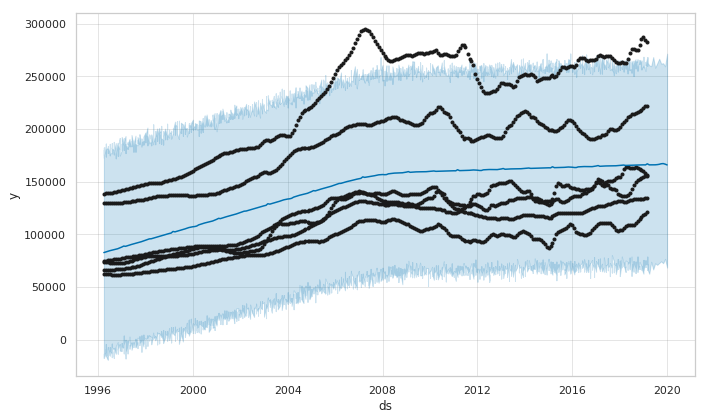

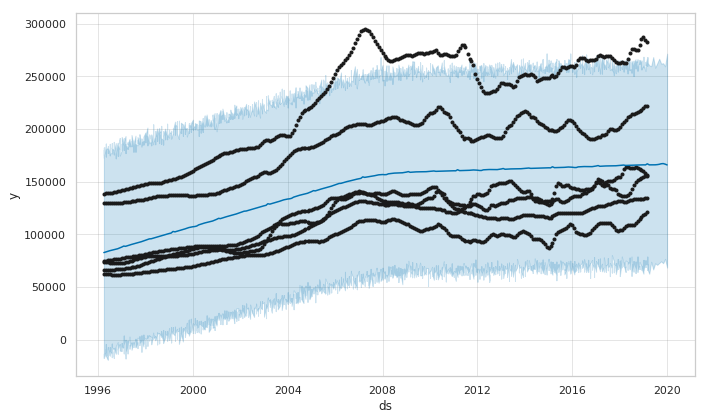

In [20]:

# MODEL

model.plot(forecast, uncertainty=True)

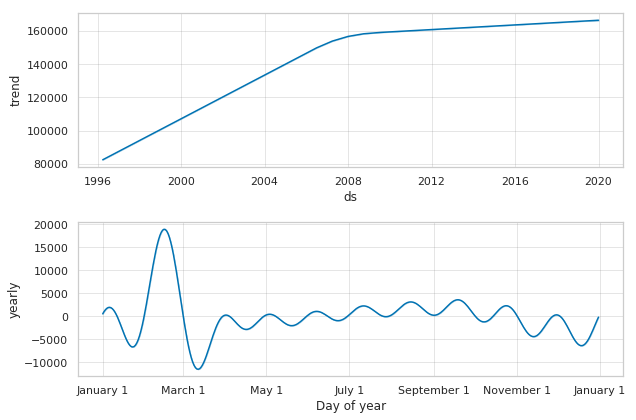

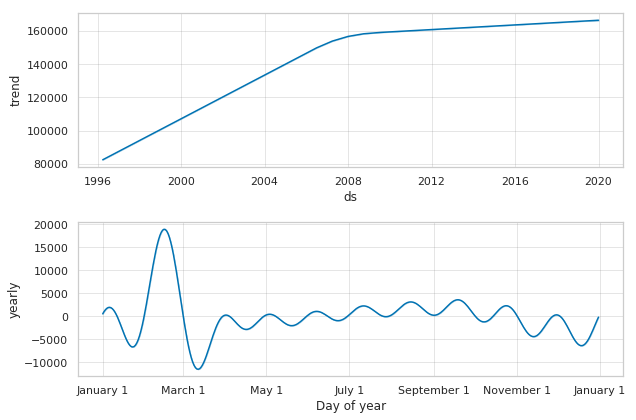

In [21]:
# INTERPRET

model.plot_components(forecast)

**Run ttest**

In [27]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing
    prices between the recession start and the recession bottom. Then
    runs a ttest comparing the university town values to the
    non-university towns values, return whether the alternative hypothesis
    (that the two groups are the same) is true or not as well as the
    p-value of the confidence.

    Returns the tuple (different, p, better) where different=True if
    the t-test is True at a p<0.01 (we reject the null hypothesis),
    or different=False if otherwise (we cannot reject the null hypothesis).
    The variable p is the exact p value returned from scipy.stats.ttest_ind().
    The value for better is either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to
    a reduced market loss).'''
    
    housing = convert_housing_data_to_quarters()
    #print(housing.head())
    university_towns = get_list_of_university_towns("university_towns.txt")
    #print(university_towns.head())
    
    quarter_before_recession = get_quarter_before_recession().lower()
    print(quarter_before_recession)
    
    recession_bottom = get_recession_bottom().lower()
    print(recession_bottom)

    # Keep columns corresponding to only two quarters:
    # quarter before recession and recession bottom
    housing = housing[[quarter_before_recession, recession_bottom]]
    #print(housing.head())
    housing["price_ratio"] = housing[quarter_before_recession].div(housing[recession_bottom])
    housing = housing.dropna()
    #print(housing.head())

    # Merge the housing dataframa with the one with the university towns taking
    # the intersection of both the dataframes. The new dataframe for housing in
    # university towns has the multi-index of States and Region names.
    university_housing = pd.merge(university_towns, housing, how = "inner",left_index = True, right_index = True)
    print(university_housing.head())

    # Left over rows from housing gives the dataframe for housing
    # in non-university towns
    non_university_housing = housing[~housing.index.isin(university_housing.index)]
    print(non_university_housing.head())

    # Testing the hypotheses
    t_stat, p_value = ttest_ind(non_university_housing["price_ratio"],university_housing["price_ratio"])
    print("t_stat: {}".format(t_stat))
    print('p_value: {}'.format(p_value))

    if p_value < 0.01:
        different = True
    else:
        different = False
    if t_stat < 0:
        better = "university town"
    else:
        better = "non-university town"
    return (different, p_value, better)
run_ttest()

2008q2
2009q2
                          2008q2         2009q2  price_ratio
State  RegionName                                           
Alaska Anchorage   296233.333333  304466.666667     0.972958
       Fairbanks   246166.666667  234000.000000     1.051994
       Juneau      305366.666667  310933.333333     0.982097
       Ketchikan   194900.000000  194800.000000     1.000513
       Sitka       309566.666667  307933.333333     1.005304
                               2008q2         2009q2  price_ratio
State   RegionName                                               
Alabama Adamsville       94000.000000   85133.333333     1.104150
        Addison          94066.666667   86733.333333     1.084550
        Alabaster       157466.666667  150300.000000     1.047682
        Alexander City   96800.000000   88566.666667     1.092962
        Argo            181866.666667  178033.333333     1.021532
t_stat: -4.339401219869867
p_value: 1.4400927982008842e-05


(True, 1.4400927982008842e-05, 'university town')

**Conclussion**

* 
*
*

**Reference**

`http://www.aashitak.com/projects/Testing-Hypothesis`

In [23]:
t = '2008Q2'
print(t.lower())

2008q2
